In [ ]:
!pip install faker
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=1d0a0232f0baed803e321688b49423f93670cb49a3d94f21087965ed802f948c
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


# Importing the libraries and initialising  Faker and a Spark session

In [ ]:
from pyspark.sql import SparkSession
from faker import Faker
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import seaborn as sns
import matplotlib.pyplot as plt

# Initialising Faker for generating fake data
fake = Faker()

# Initialising SparkSession
spark=SparkSession.builder.appName('Customer_Substitution').getOrCreate()

# Set the random seed for Faker
fake.seed_instance(42)

# Generating Data Using Faker

In [ ]:
# Data for the Customers table
customer_data = []
num_cust = 100 # number of customers
for i in range(num_cust + 1):
    customer = {
        "CustomerId": i + 1,
        "FullName": fake.name(),
        "Gender": fake.random_element(["Male", "Female"]),
        "DateOfBirth": fake.date_of_birth(minimum_age=18, maximum_age=65),
        "NativeGeography": fake.country(),
        "Education": fake.random_element(["Bachelor's Degree", "Master's Degree", 'PhD']),
        "Occupation": fake.random_element(["Data Analyst", "Founder", "Software Developer"]),
        "AnnualSalary": float(fake.random_int(min=500000, max=4000000)),
        "ProfileCategory": fake.random_element(["M", "N", "O"])
    }
    customer_data.append(customer)

In [ ]:
# Data for the Products table
product_data = []
num_prod = 600 # number of total products
for j in range(num_prod + 1):
    product = {
        "ProductId": j + 1,
        "SystemUniqueKey": fake.text(),
        "ProductName": fake.word(),
        "ProductDescription": fake.sentence(),
        "Category": fake.random_element(["Clothing", "Home & Kitchen", "Beauty", "Sports", "Electronics"]),
        "ListPrice": float(fake.random_int(min=10, max=1000)),
        "RetailSalePrice": float(fake.random_int(min=10, max=1000))
    }
    product_data.append(product)

In [ ]:
# Data for the Transactions table
transaction_data = []
for k in range(50000):
    # making sure that the customer_id and product_id has equal numbers
    customer_id = fake.random_int(min=1, max=num_cust)
    product_id = fake.random_int(min=1, max=num_prod)
    transaction = {
        "TransactionId": fake.uuid4(),
        "Source": fake.word(),
        "SystemUniqueKey": str(fake.random_int()),
        "Description": fake.sentence(),
        "ProductId": str(product_id),
        "CustomerId": str(customer_id),
        "StoreId": fake.uuid4(),
        "DistributorId": fake.uuid4(),
        "SKUName": fake.word(),
        "Quantity": float(fake.random_int(min=1, max=100)),
        "Unit": fake.word(),
        "TransactionDate": fake.date_time_between(start_date="-2y", end_date="now"),
        "SaleAmount": float(fake.random_int(min=5000, max=50000)),
        "SaleVolume": float(fake.random_int(min=1, max=100)),
        "ExportCountry": fake.country(),
        "ReferenceCodeUsed": str(fake.random_int()),
        "CampaignCodeUsed": str(fake.random_int()),
        "DiscountValue": float(fake.random_int(min=0, max=100))
    }

    transaction_data.append(transaction)


In [ ]:
# Converting the lists to Spark DataFrames for further use
customer_df = spark.createDataFrame(customer_data)
product_df = spark.createDataFrame(product_data)
transaction_df = spark.createDataFrame(transaction_data)

customer_df.show(5)
product_df.show(5)
transaction_df.show(5)

+------------+----------+-----------+-----------------+-------------------+------+--------------------+------------------+---------------+
|AnnualSalary|CustomerId|DateOfBirth|        Education|           FullName|Gender|     NativeGeography|        Occupation|ProfileCategory|
+------------+----------+-----------+-----------------+-------------------+------+--------------------+------------------+---------------+
|   3606585.0|         1| 1966-12-30|Bachelor's Degree|       Allison Hill|  Male|Saint Pierre and ...|Software Developer|              O|
|   2854032.0|         2| 1973-05-01|              PhD|     Javier Johnson|  Male|          Madagascar|      Data Analyst|              M|
|   3428208.0|         3| 1997-08-07|Bachelor's Degree|    Meredith Barnes|Female|                Fiji|      Data Analyst|              N|
|   2005668.0|         4| 1964-06-15|  Master's Degree|Christopher Bernard|Female|             Bermuda|      Data Analyst|              N|
|   3978775.0|         5| 1

# Data Preparation and pre-processing

In [ ]:
# Combining the dataframes into one combined table
combined_df = transaction_df.join(customer_df, "CustomerId").join(product_df, "ProductId")

# Selecting required columns for analysis
combined_df = combined_df.select(transaction_df["TransactionId"],
                                  transaction_df["TransactionDate"],
                                  transaction_df["SaleAmount"],
                                  customer_df["CustomerId"],
                                  customer_df["FullName"],
                                  product_df["ProductId"],
                                  product_df["Category"],
                                  product_df["ListPrice"])

combined_df.show(10)
combined_df.filter(F.col('FullName') == 'Corey Wilson').orderBy('TransactionDate').show()

+--------------------+-------------------+----------+----------+-----------------+---------+--------------+---------+
|       TransactionId|    TransactionDate|SaleAmount|CustomerId|         FullName|ProductId|      Category|ListPrice|
+--------------------+-------------------+----------+----------+-----------------+---------+--------------+---------+
|92c987c1-7c5d-4d4...|2021-11-26 12:56:58|   19725.0|        26|Matthew Fernandez|      383|        Beauty|    409.0|
|ae46f81c-60f6-4f1...|2022-02-27 17:44:59|   49625.0|        26|Matthew Fernandez|      568|        Sports|    662.0|
|7e851076-9db0-4ca...|2023-01-29 14:06:58|   40190.0|        26|Matthew Fernandez|      313|Home & Kitchen|    810.0|
|8affd5e7-9f92-4a0...|2022-06-24 23:34:48|   40649.0|        26|Matthew Fernandez|      273|        Beauty|    605.0|
|eef65291-995b-4c4...|2022-12-29 03:53:22|   28680.0|        26|Matthew Fernandez|      249|   Electronics|    486.0|
|d9fdc5f7-e290-4dc...|2021-12-03 11:56:07|    6267.0|   

In [ ]:
# Transaction ID serves as a primary key (Unique Identifier for every transaction)
# No duplicate values in the transaction ID
duplicate_counts = combined_df.groupBy(F.col('TransactionId')).count().filter(F.col("count") > 1)
duplicate_counts.show()

+-------------+-----+
|TransactionId|count|
+-------------+-----+
+-------------+-----+



# Preliminary Visualization of the Transaction and Product data

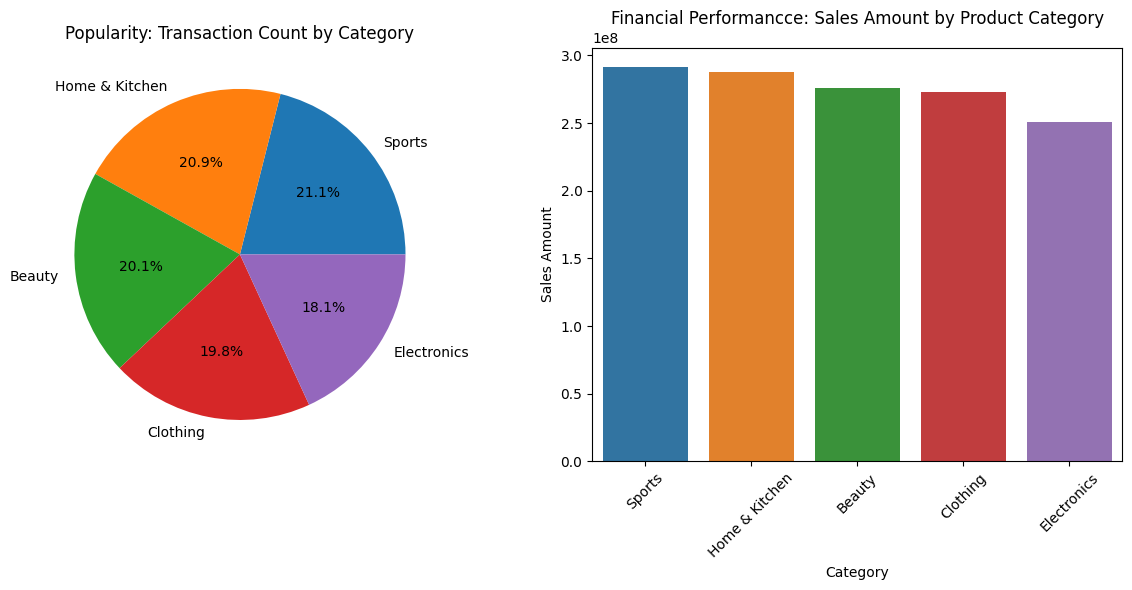

In [ ]:
# Counts and sales for each category items
category_counts = combined_df.groupBy("Category").count().orderBy("count", ascending=False)
category_sales = combined_df.groupBy("Category").sum("SaleAmount").orderBy("sum(SaleAmount)", ascending=False)

# Getting the data in a list
category_labels = [row["Category"] for row in category_counts.collect()]
category_counts = [row["count"] for row in category_counts.collect()]
sales_amounts = [row["sum(SaleAmount)"] for row in category_sales.collect()]

# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Transaction Count by Product Category
ax1.pie(category_counts, labels=category_labels, autopct='%1.1f%%')
ax1.set_title("Popularity: Transaction Count by Category")

# Sales Amount by Product Category
sns.barplot(x=category_labels, y=sales_amounts, ax=ax2)
ax2.set_xlabel("Category")
ax2.set_ylabel("Sales Amount")
ax2.set_title("Financial Performancce: Sales Amount by Product Category")
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()

# Analysing the trend using **Moving average**
Trend analysis for customers and product based on their sale amounts.

1. Calculate the moving average for each customer using a defined time window.
2. Handling the missing values in the initial rows depending on the time window.
3. ***Logic*** for deciding a downtrend or uptrend
   - Calculate the percentage change between consecutive moving averages for each customer.
  - Compute the average percentage change for each customer.
  - If the average is negative then it would indicate a downward trend.  
4. Determine the trend for each customer based on the average percentage change: "**Upward**" for positive or zero change, "**Downward**" for negative change.

***Alternate logic***: Fit a line, if the slope is negative then it is a downtrend.


### Trend for Customers
*Introduced a downward trend for this part of the data for better visualization of downward substitution*

In [ ]:
# Time window for moving average
time = 40

# Trend factor to decrease the sale amount gradually
trend_factor = 0.995

# Calculating moving averages for customers based on SaleAmount
window_spec_customer = Window.partitionBy("FullName").orderBy("TransactionDate")
combined_df_customer = combined_df.withColumn("MovingAverage_Customer", F.avg("SaleAmount").over(window_spec_customer.rowsBetween(-time, 0)))

# Adjusting the moving average values for the initial rows of each customer
combined_df_customer = combined_df_customer.withColumn("MovingAverage_Customer", F.when(F.row_number().over(window_spec_customer) < time, None).otherwise(F.col("MovingAverage_Customer")))

# Applying a gradual decrease to the sale amount based on the trend factor according to time
combined_df_customer = combined_df_customer.withColumn("SaleAmount", F.col("SaleAmount") * (F.pow(trend_factor, F.row_number().over(window_spec_customer)))).orderBy("TransactionDate")

# Calculating the moving average for the decreased sale amount
window_spec_customer_decreased = Window.partitionBy("FullName").orderBy("TransactionDate")
combined_df_customer = combined_df_customer.withColumn("MovingAverage_Customer_Decreased", F.avg("SaleAmount").over(window_spec_customer_decreased.rowsBetween(-time, 0)))

# Adjusting the moving average values for the initial rows of each customer with decreased sale amount
combined_df_customer = combined_df_customer.withColumn("MovingAverage_Customer_Decreased", F.when(F.row_number().over(window_spec_customer_decreased) < time, None).otherwise(F.col("MovingAverage_Customer_Decreased")))

# Calculating the percentage change between consecutive moving averages for each customer with decreased sale amount
combined_df_customer = combined_df_customer.withColumn("PercentageChange_Customer_Decreased", (F.col("MovingAverage_Customer_Decreased") - F.lag(F.col("MovingAverage_Customer_Decreased")).over(window_spec_customer_decreased)) / F.lag(F.col("MovingAverage_Customer_Decreased")).over(window_spec_customer_decreased))

# Dropping Null Values
combined_df_customer = combined_df_customer.dropna()

# Determining the trend (downward or upward) based on the average percentage change with decreased sale amount
average_change_customer = combined_df_customer.groupBy("FullName").agg(F.avg("PercentageChange_Customer_Decreased").alias("AvgChange_Customer_Decreased"))
trend_customer = average_change_customer.withColumn("Trend_Customer", F.when(F.col("AvgChange_Customer_Decreased") < 0, "Downward").otherwise("Upward")).select(['FullName', 'Trend_Customer'])
trend_customer.show()


+-------------------+--------------+
|           FullName|Trend_Customer|
+-------------------+--------------+
|      Adam Mitchell|      Downward|
|      Allison Perez|      Downward|
|       Amber Wright|      Downward|
|        Andrew Diaz|      Downward|
|     Ashley Brennan|      Downward|
|     Austin Vasquez|      Downward|
|     Benjamin Welch|      Downward|
|      Brandy Wilson|      Downward|
|  Brenda Snyder PhD|      Downward|
|       Brenda White|      Downward|
|  Christina Walters|      Downward|
|Christopher Bernard|      Downward|
|  Christopher Jones|      Downward|
| Christopher Parker|      Downward|
|       Corey Wilson|      Downward|
|        Daniel Holt|      Downward|
|        David Walsh|      Downward|
|   Denise Davenport|      Downward|
|       Devon Flores|      Downward|
|   Dillon Fernandez|      Downward|
+-------------------+--------------+
only showing top 20 rows



### Trend for Product categories (independent of customers) - can be modified for specific products

In [ ]:
#### PRODUCT ANALYSIS

# Time window for moving average
time = 40

# Calculating moving averages for product categories based on SaleAmount
window_spec_category = Window.partitionBy("Category").orderBy("TransactionDate")
combined_df_category = combined_df.withColumn("MovingAverage_Category", F.avg("SaleAmount").over(window_spec_category.rowsBetween(-time, 0)))

# Adjusting the moving average values for the initial rows of each category
combined_df_category = combined_df_category.withColumn("MovingAverage_Category", F.when(F.row_number().over(window_spec_category) < time, None).otherwise(F.col("MovingAverage_Category")))

# Calculating the percentage change between consecutive moving averages for each category
combined_df_category = combined_df_category.withColumn("PercentageChange_Category", (F.col("MovingAverage_Category") - F.lag(F.col("MovingAverage_Category")).over(window_spec_category)) / F.lag(F.col("MovingAverage_Category")).over(window_spec_category))

# Dropping Null Values
combined_df_category = combined_df_category.dropna()

# Determining the trend (upward or downward) based on the average percentage change
average_change_category = combined_df_category.groupBy("Category").agg(F.avg("PercentageChange_Category").alias("AvgChange_Category"))
trend_category = average_change_category.withColumn("Trend_Category", F.when(F.col("AvgChange_Category") < 0, "Downward").otherwise("Upward")).select(['Category', 'Trend_Category'])
trend_category.show()

+--------------+--------------+
|      Category|Trend_Category|
+--------------+--------------+
|Home & Kitchen|        Upward|
|        Sports|        Upward|
|        Beauty|        Upward|
|      Clothing|        Upward|
|   Electronics|        Upward|
+--------------+--------------+



### Trend for cutomers according to Product categories

In [ ]:
# Time window for moving average
time = 40

# Calculating moving averages for products based on SaleAmount
window_spec_category = Window.partitionBy("FullName", "Category").orderBy("TransactionDate")
combined_df_customer_category  = combined_df.withColumn("MovingAverage_Cust_Category", F.avg("SaleAmount").over(window_spec_category.rowsBetween(-time, 0)))

# Adjusting the moving average values for the initial rows of each product
combined_df_customer_category = combined_df_customer_category.withColumn("MovingAverage_Cust_Category", F.when(F.row_number().over(window_spec_category) < time, None).otherwise(F.col("MovingAverage_Cust_Category")))

# Calculating the percentage change between consecutive moving averages for each product
combined_df_customer_category = combined_df_customer_category.withColumn("PercentageChange_Cust_Category", (F.col("MovingAverage_Cust_Category") - F.lag(F.col("MovingAverage_Cust_Category")).over(window_spec_category)) / F.lag(F.col("MovingAverage_Cust_Category")).over(window_spec_category))

# Dropping Null Values
combined_df_customer_category = combined_df_customer_category.dropna()

# Determining the trend (upward or downward) based on the average percentage change
average_change_customer_category = combined_df_customer_category.groupBy("FullName", "Category").agg(F.avg("PercentageChange_Cust_Category").alias("AvgChange_Cust_Category"))
trend_customer_category = average_change_customer_category.withColumn("Trend_Customer_Category", F.when(F.col("AvgChange_Cust_Category") < 0, "Downward").otherwise("Upward")).select(['FullName', 'Category', 'Trend_Customer_Category'])
trend_customer_category.show()

+--------------+--------------+-----------------------+
|      FullName|      Category|Trend_Customer_Category|
+--------------+--------------+-----------------------+
| Adam Mitchell|   Electronics|                 Upward|
| Adam Mitchell|        Sports|                 Upward|
|Alicia Gilmore|      Clothing|                 Upward|
| Allen Rosales|        Beauty|               Downward|
| Allen Rosales|      Clothing|                 Upward|
| Allen Rosales|Home & Kitchen|               Downward|
| Allen Rosales|        Sports|                 Upward|
|  Allison Hill|        Beauty|                 Upward|
|  Allison Hill|Home & Kitchen|                 Upward|
| Allison Perez|      Clothing|                 Upward|
|  Amber Wright|      Clothing|               Downward|
|  Amber Wright|   Electronics|                 Upward|
|  Amber Wright|Home & Kitchen|               Downward|
|   Amy Edwards|        Beauty|                 Upward|
|   Amy Edwards|Home & Kitchen|                 

# Identifying Downward Substitution

In [ ]:
Downward_Cust = trend_customer.filter(F.col("AvgChange_Customer_Decreased") < 0)
Downward_Category = trend_category.filter(F.col("AvgChange_Category") < 0)
Downward_Customer_Category = trend_customer_category.filter(F.col("AvgChange_Cust_Category") < 0)

# Show 10 results
Downward_Cust.show(10)
Downward_Category.show(10)
Downward_Customer_Category.show(10)

+-----------------+--------------+
|         FullName|Trend_Customer|
+-----------------+--------------+
|    Adam Mitchell|      Downward|
|    Allison Perez|      Downward|
|     Amber Wright|      Downward|
|      Andrew Diaz|      Downward|
|   Ashley Brennan|      Downward|
|   Austin Vasquez|      Downward|
|   Benjamin Welch|      Downward|
|    Brandy Wilson|      Downward|
|Brenda Snyder PhD|      Downward|
|     Brenda White|      Downward|
+-----------------+--------------+
only showing top 10 rows

+--------+--------------+
|Category|Trend_Category|
+--------+--------------+
+--------+--------------+

+--------------+--------------+-----------------------+
|      FullName|      Category|Trend_Customer_Category|
+--------------+--------------+-----------------------+
| Allen Rosales|        Beauty|               Downward|
| Allen Rosales|Home & Kitchen|               Downward|
|  Amber Wright|      Clothing|               Downward|
|  Amber Wright|Home & Kitchen|            

# Analysis for specific customers and products to view the moving average

In [ ]:
# Analysis for a specific customer

# Filter the data for the customer with maximum occurrences (To get maximum available data)
max_occ_custid = combined_df_customer.groupBy("CustomerId").count().orderBy(F.desc("count")).first()[0]
customer1 = combined_df_customer.filter(F.col("CustomerId") == max_occ_custid).orderBy("TransactionDate")

customer1.show()

+--------------------+-------------------+------------------+----------+-------------+---------+--------------+---------+----------------------+--------------------------------+-----------------------------------+
|       TransactionId|    TransactionDate|        SaleAmount|CustomerId|     FullName|ProductId|      Category|ListPrice|MovingAverage_Customer|MovingAverage_Customer_Decreased|PercentageChange_Customer_Decreased|
+--------------------+-------------------+------------------+----------+-------------+---------+--------------+---------+----------------------+--------------------------------+-----------------------------------+
|0a7b4bda-5c80-4da...|2021-08-13 11:11:32|28156.022236039254|        82|Adam Mitchell|       57|   Electronics|    679.0|    28772.121951219513|              25988.972501187487|               0.002088940388531...|
|67185b84-4147-4a7...|2021-08-14 07:50:54|  6714.58434733464|        82|Adam Mitchell|       53|Home & Kitchen|    989.0|    28419.219512195123|

### Plot showing moving average for one customer for its entire transactions accross all product categories

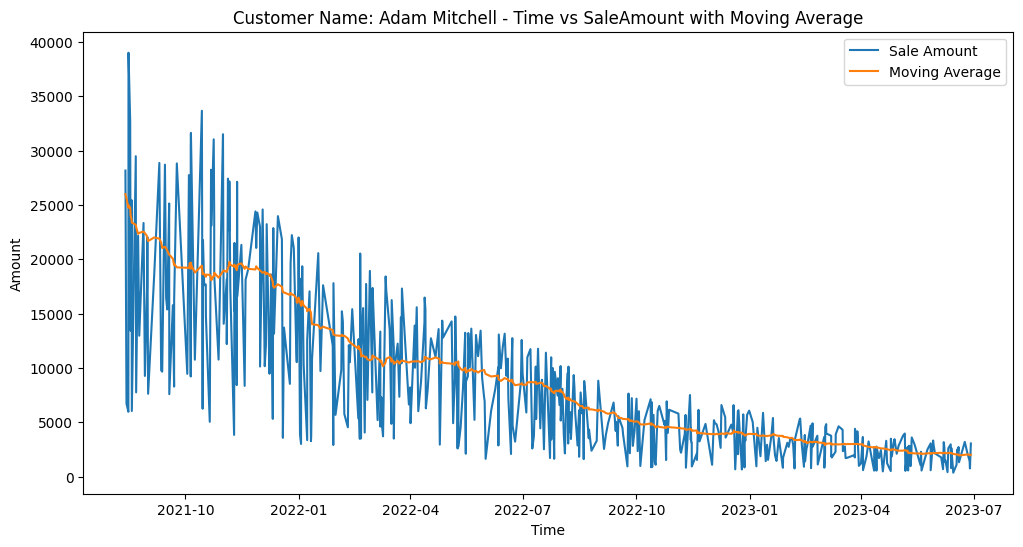

In [ ]:
# Extracting the time and sale amount data for the customer
time_data = [row["TransactionDate"] for row in customer1.collect()]
amount_data = [row["SaleAmount"] for row in customer1.collect()]
moving_avg_data = [row["MovingAverage_Customer_Decreased"] for row in customer1.collect()]

# Customer name
customer_name = customer1.select("FullName").first()[0]

# Time vs amount for the customer with moving average
plt.figure(figsize=(12, 6))
plt.plot(time_data, amount_data, label="Sale Amount")
plt.plot(time_data, moving_avg_data, label="Moving Average")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.title(f"Customer Name: {customer_name} - Time vs SaleAmount with Moving Average")
plt.legend()

plt.show()


### Plot showing moving average for one customer for its entire transactions for one particular product category

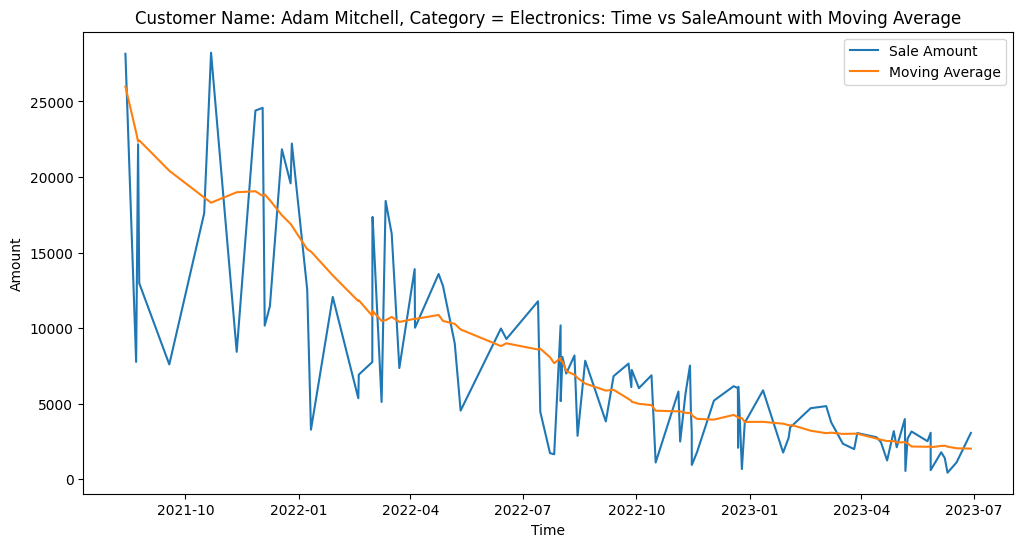

In [ ]:
# Specify the desired customer and product category
Category_name = "Electronics"

# Filter the DataFrame for the specified customer and category
product1 = customer1.filter(F.col("Category") == Category_name).orderBy("TransactionDate")

# Extracting the time and sale amount data for the customer
time_data = [row["TransactionDate"] for row in product1.collect()]
amount_data = [row["SaleAmount"] for row in product1.collect()]
moving_avg_data = [row["MovingAverage_Customer_Decreased"] for row in product1.collect()]

# Time vs amount for the customer and a product category with moving average
plt.figure(figsize=(12, 6))
plt.plot(time_data, amount_data, label="Sale Amount")
plt.plot(time_data, moving_avg_data, label="Moving Average")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.title(f"Customer Name: {customer_name}, Category = {Category_name}: Time vs SaleAmount with Moving Average")
plt.legend()

plt.show()